
## The Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines. They collect four kinds of time series data for each machine in their fleet. When a machine is operating in normal mode the data behaves in a fairly predictable way, but with a moderate amount of noise. Before a machine fails it will ramp into faulty mode, during which the data appears visibly quite different. Finally, when a machine fails it enters a third, and distinctly different, failed mode where all signals are very close to zero. There are four common sensors associated with each machine. There is also static data associated with each machine.

ExampleCo stores their data in SQL tables. While SQL is useful for storing and querying data, it is less useful as input for machine learning pipelines. At Tagup, our ML Pipelines expect data as an n-dimensional array, and a common first step is converting a customer's data from SQL to array form.

You can download the data here: [exampleco_data](https://drive.google.com/file/d/1GejVDBoFFVNprqMeTGnXu8hrYLj4aS4q/view?usp=sharing)

Your objectives are:

- Map the equipment data from SQL into arrays (or a single array). To keep things simple, you can ignore the static data to start. Be sure to describe your design choices and the array schema you chose.
- Apply filters to clean the data. For example, there are some clear outliers in the data due to communication errors from the sensor equipment. These bad measurements have no bearing on the ability for Tagup to provide insight from the data, and a good place to start is to find a way to filter them out.

Bonus points:
- Provide summary statistics for the ingressed data, including various statistical moments, and any other relevant descriptive statistics.
- Integrate the static data into your design.  
- As part of a data processing pipeline, upload your arrays to AWS S3.
- Demonstrate the efficacy of your approach using visualizations. You must also include a simple explanation of these figures and why your approach is effective, written in language that non-technical executives could understand.
    
A few notes to help:
1. Feel free to use any libraries you like. At Tagup, we use [xarray](http://xarray.pydata.org/en/stable/) for multidimensional arrays, but you can use whatever methods you prefer. Your final results should be shared via GitHub, including a README file providing documentation (ideally of both your code and your findings in the data). There is a jupyter notebook included to help you get started, but do not feel obligated to submit your solution in notebook form.
    
2. There are no constraints on the techniques you bring to bear, we are curious to see how you think and what sort of resources you have in your toolbox.
    
3. Don't hesitate to reach out to challenges@tagup.io with any questions!
    

## Tips
- We value syntax, structure and variable naming, code documentation, and testability.
- Try to design and implement your solution as you would do for real production code. Show us how you create clean and maintainable code that produces the target result. Build something that we'd be happy to contribute to.
- Feel free to add more features: we're curious about what you can think of. We'd expect the same if you worked with us!


# Here is some code to help you get started
Feel free to modify or remove any of this.

In [352]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sqlalchemy import create_engine, inspect

In [353]:
# Load db
engine = create_engine('sqlite:///exampleco_db.db', echo=False)

In [354]:
# View tables
inspector = inspect(engine)
inspector.get_table_names()

['feat_0', 'feat_1', 'feat_2', 'feat_3', 'static_data']

In [355]:
n=4 #number of feat tables

In [356]:
#load tables into list of pandas dataframes for each table
dfs=[]
for i in range(n):
    cols=list(engine.execute(f"SELECT * FROM feat_{i}").keys())
    cols[-1]+=f"_{i}" #rename value to show which tool it was from
    query = f"SELECT * FROM feat_{i};"
    dfs.append(pd.DataFrame(engine.execute(query).fetchall(),columns=cols))

In [357]:
dfp=[] #array of pivoted values
for i in range(n):
    df=dfs[i].pivot(index="timestamp", columns="machine", values=f"value_{i}")
    
    #sort in order of machines
    new_order=sorted(df.columns, key=lambda x: (int(x.split('_')[1])))
    df=df[new_order]
    
    dfp.append(df)

Now we have 4 dataframes that each have the different values for all the machine measurements for each timestamp. This is useful because if we want all the measurements from a machine from a certain sensor we can just choose the corresponding column in the corresponding table. For now we represent these as pandas dataframes-easy to manipulate and clean data, and we can later turn into other types of arrays easily.

Below is an example of a plot of the values of a machine over time (the x axis is the number entry which is increasing in time).
We can clearly see the three states: up to about 1500 the machine is operating in the normal range, from 1500-1700 it is in the faulty range, 
and afterwards it has failed. We can also clearly see the outliers, the values which have above absolute value of about 200 or greater.

<AxesSubplot:>

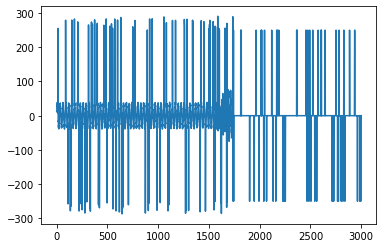

In [358]:
(dfp[0].set_index(pd.Index(range(3000))))['machine_1'].plot()

Similarly, here is an example boxplot. The standard deviation is small, caused by the fact that that after the machine fails it stays very close to zero. However, it is easy to see the grouping of outliers to the far left and right. The more intermediate values a little less than 100 are from working/faulty mode. (This graph for now is mostly just for visualizing outliers--quartiles not super meaningful because of different stages of the machine)

<AxesSubplot:xlabel='machine_15'>

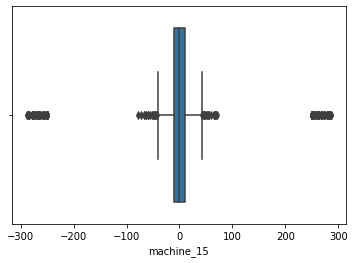

In [359]:
sns.boxplot(x=dfp[0]['machine_15'])

After observing a lot of the plots, these outliers are a common error and it doesn't seem like the machines naturally hit values this high. We now have a couple options. We could delete the rows that include these outliers, but this involves deleting a lot of rows and losing a lot of data. We can replace the outlier with NaNs, but we don't know if machine learning model will work with these values. I decided to instead use linear interpolation, which seems like it will work reasonably with our data because there aren't any crazy patterns, and since our data is evenly spaced in time a missing time is evenly between two other times.

We will replaces values with an absolute value greater than 200 (these seem to be where our outliers lie).

In [360]:
dfo=[] #array of data frames with outliers removed
for i in range(n):
    df=dfp[i]
    df=df[abs(df)<200] #replaces values greater than 200 with NaN
    df=df.interpolate(method='linear')
    df=df.fillna(method='bfill') #if first or last value, might be a nan still-then just copy 2nd or 2nd to last measurement
    df=df.fillna(method='ffill')
    dfo.append(df)

Below is the graph from above but with these large outliers interpolated--much cleaner, and we can see the three stages!

<AxesSubplot:>

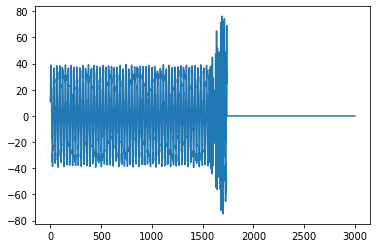

In [361]:
l=dfo[0].shape[0]
dfo[0].set_index(pd.Index(range(l)))['machine_1'].plot()

Next we will pull some interesting data from this. For example, when does each machine fail? 
We can estimate this by finding the first time where the next couple values for a machine are close to 0.

In [362]:
k=5 #number of consecutive small values considered needed for machine to have failed
tol=.1 #number when value is below is considered small, candidate for having failed
fails=[] #datetime of failure
fails_num=[] #num row of failure
for i in range(n):
    f=[]
    f_num=[]
    df=dfo[i]
    l=df.shape[0]
    for j in range(df.shape[1]):
        for m in range(l-k):
            if np.all(np.abs(df.iloc[m:m+k,j])<tol):
                f.append(df.index[m])
                f_num.append(m)
                break
    fails.append(f)
    fails_num.append(f_num)
#fails[i][j] is estimate of time machine j failed according to sensor i

Another interesting value could be mean and variance of machine/sensor before it fails, found below

In [363]:
mean=[]
var=[]
for i in range(n):
    m=[]
    v=[]
    df=dfo[i]
    l=df.shape[0]
    for j in range(df.shape[1]):
        pre_fail_rows=df.iloc[:fails_num[i][j],j]
        m.append(np.mean(pre_fail_rows))
        v.append(np.var(pre_fail_rows))
    mean.append(m)
    var.append(v)
#mean/var[i][j] is mean/var of sensor i, machine j

So we have approximate failure timestamps and some descriptive statistics for the machines before they fail. With more time, we could find and look for patterns in these failure times. Also the variance we have represents both normal and faulty modes, and it is different for the two, so really it would be better to find these descriptive statistics for each mode the machine is in.

Here's an idea for some further work we could do to estimate when a machine is in the faulty mode. First throw out all the data after the calculated failure time. Next choose some number of consecutive data points (let's say maybe 20) and split the data up into len(data)/20 different groups which each consist of 20 consecutive data points. Next find the max absolute value of the data for each of these groups. From analyzing the graphs it seems like this max stays pretty similar while the machine is operating regularly. Now find when this max starts to significantly increase (and continues to increase) and that will be around when the faulty mode starts.

For now will just examine static data.

In [364]:
cols=list(engine.execute(f"SELECT * FROM static_data").keys())
query = f"SELECT * FROM static_data;"
df_s=pd.DataFrame(engine.execute(query).fetchall(),columns=cols)

,machine_id,install_date,model,room
0,machine_0,2019-01-01,Model A,Room 123
1,machine_1,2019-01-01,Model A,Room 123
2,machine_2,2019-01-01,Model A,Room 123
3,machine_3,2019-01-01,Model A,Room 123
4,machine_4,2019-01-01,Model A,Room 123
5,machine_5,2019-01-01,Model A,Room 123
6,machine_6,2019-01-01,Model A,Room 123
7,machine_7,2019-01-01,Model A,Room 123
8,machine_8,2019-01-01,Model A,Room 123
9,machine_9,2019-01-01,Model A,Room 123


From observing static data, we see that machines 0 through 13 are model A, 14 through 19 are model B. If we are inputting this data into a machine learning algorithm we might want to do separate models for each type of machine

In [365]:
dfa=[] #model a dataframes. df_a[i] has values for model A machines for sensor i
dfb=[] #model b dataframes. df_b[i] has values for model B machines for sensor i
for i in range(n):
    df=dfo[i]
    c1=df.columns[:14]
    c2=df.columns[14:]
    dfa.append(df[c1])
    dfb.append(df[c2])

We can easily turn these into xarrays if we wanted to

In [366]:
xf=[] #final list of xarrays for all machines (1 for each sensor)
xa=[] #final list of xarrays for model A machines
xb=[] #final list of xarrays for model B machines
for df in dfo:
    xf.append(df.to_xarray())
for df in dfa:
    xa.append(df.to_xarray())
for df in dfb:
    xb.append(df.to_xarray())  

In [367]:
for i in range(n):
    dfo[i].to_csv(f'feat_{i}.csv')